In [1]:
# import torch
# import torchvision
# import torchvision.transforms as transforms
# import matplotlib.pyplot as plt
import numpy as np
# import pylab
from datetime import datetime

# import os
# import math
# import random
import pandas as pd
# import itertools
from scipy.io import loadmat
# from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import h5py
from torch.utils.data.dataset import Dataset
from sklearn.metrics import balanced_accuracy_score

In [2]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.3.1
Torchvision Version:  0.4.2


In [3]:

torch.cuda.is_available()

True

In [4]:
import torchvision.models as models
import torch.nn as nn
resnet = models.resnet18()

In [5]:

model_name = "resnet"

# Number of classes in the dataset
num_classes = 3

# Batch size for training (change depending on how much memory you have)
batch_size = 512

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [6]:
# #Rasnet18
# resnet.conv1 = nn.Conv2d(in_channels=40, out_channels=64, kernel_size=7,stride=2, padding=3, bias=False)
# resnet.fc = nn.Linear(2048, num_classes)

In [7]:
def train_model(model, dataloaders, criterion, optimizer, optimizer2, num_epochs=25, is_inception=False):
    since = time.time()
    start = datetime.now()
    val_acc_history = []
    train_acc_history = []
    val_Bacc_history = []
    train_Bacc_history = []
    val_loss_history = []
    train_loss_history = []
    lr_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 1e10
#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=1, min_lr=0, eps=1e-08)
    scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer2, mode='min', factor=0.5, patience=5, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=1, min_lr=0, eps=1e-08)
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            LabelList = torch.tensor([1]).to(device)
            PredList = torch.tensor([1]).to(device)
            if phase == 'train':
                if epoch < 5:
                    for param_group in optimizer.param_groups:
                        print("LR", param_group['lr'])
                        lr_history.append(param_group['lr'])
                else:
                    for param_group in optimizer2.param_groups:
                        print("LR", param_group['lr'])
                        lr_history.append(param_group['lr'])
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            epoch_samples = 0
            confusion_matrix = torch.zeros(3, 3)
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.type(torch.FloatTensor)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                if epoch < 5:
                    optimizer.zero_grad()
                else:
                    optimizer2.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                     # statistics
                    epoch_samples += inputs.size(0)
                    LabelList = torch.cat([LabelList,labels.view(-1)],dim=0)
                    PredList = torch.cat([PredList, preds.view(-1)],dim=0)
#                     # statistics
#                     for t, p in zip(labels.view(-1), preds.view(-1)):
#                         confusion_matrix[t.long(), p.long()] += 1

                    running_corrects += torch.sum(preds == labels.data)


#                 confusionMat = np.asarray(confusion_matrix)
#                 sumconfusion = np.sum(confusionMat,axis = 1).T

#                 summat = np.tile(sumconfusion,(3,1)).T
                # print(test)
#                 percentconfusion = np.divide(confusionMat,summat)
                epoch_acc_balanced =  balanced_accuracy_score(LabelList[1:].cpu(), PredList[1:].cpu())

                # statistics
                running_loss += loss.item() * inputs.size(0)
#                 running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
        

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print('{} Bal. Acc: {:.4f}'.format(phase, epoch_acc_balanced))
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                print("saving best model")
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_loss = epoch_loss
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_Bacc_history.append(epoch_acc_balanced)
                val_loss_history.append(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_Bacc_history.append(epoch_acc_balanced)
                train_loss_history.append(epoch_loss)
#             if epoch_acc == 1:
#                 break
            
        print("Total time: %s" %(datetime.now() - start))
        time_elapsed = time.time() - since
        print('Epoch time: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print()
        if epoch < 5:
            scheduler.step(epoch_loss)
        else:
            scheduler2.step(epoch_loss)
#         if epoch >= 6  and val_loss_history [-1] >= val_loss_history [-2] >= val_loss_history [-3] >= val_loss_history[-4]>=val_loss_history[-5]>=val_loss_history[-6]:
#             break
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history,train_acc_history,train_loss_history, val_loss_history,lr_history,train_Bacc_history,val_Bacc_history

In [8]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [9]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7,stride=2, padding=3, bias=False)
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 1
    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
DatadirTrain = "H:\\WBCDataset_v4\\2DProjectionsKFold-aug"
DatadirVal = "H:\\WBCDataset_v4\\2DProjectionsKFold-aug"

In [11]:
# import os
# import os.path

# for dirpath, dirnames, filenames in os.walk("."):
#     for filename in [f for f in filenames if f.endswith(".log")]:
#         print os.path.join(dirpath, filename)
FoldName = ["Fold-1","Fold-2","Fold-3","Fold-4","Fold-5"]
tempName =FoldName
ValFold = tempName.pop(1)
# FoldName = tempName
print(FoldName)
print(ValFold)
for name in FoldName:
    print(name)

['Fold-1', 'Fold-3', 'Fold-4', 'Fold-5']
Fold-2
Fold-1
Fold-3
Fold-4
Fold-5


In [12]:
import os

def datapreparation(DatadirTrain,DatadirVal,Fold):
    trainpath = []
    FoldName = ["Fold-1","Fold-2","Fold-3","Fold-4","Fold-5"]
    ValFold = FoldName.pop(Fold)
    
    fpath = []
    traindir = DatadirTrain + "\\Gra_Y"
    for name in FoldName:
        trainsubdir = traindir + "\\" + name
        for dirpath, dirnames, filenames in os.walk(trainsubdir):
            for filename in [f for f in filenames if f.endswith(".tif")]:
                tempfpath =os.path.join(dirpath, filename)
                fpath.append(tempfpath)
    train = list(range(1,len(fpath)))
    print('Gra train data: %d' %(len(train)))
    for i in train:
        trainpath.append(fpath[i])

    fpath = []
    traindir = DatadirTrain + "\\Lym_G"
    for name in FoldName:
        trainsubdir = traindir + "\\" + name
        for dirpath, dirnames, filenames in os.walk(trainsubdir):
            for filename in [f for f in filenames if f.endswith(".tif")]:
                tempfpath =os.path.join(dirpath, filename)
                fpath.append(tempfpath)
    train = list(range(1,len(fpath)))
    print('Lym train data: %d' %(len(train)))
    for i in train:
        trainpath.append(fpath[i])

    fpath = []
    traindir = DatadirTrain + "\\Mon_U"
    for name in FoldName:
        trainsubdir = traindir + "\\" + name
        for dirpath, dirnames, filenames in os.walk(trainsubdir):
            for filename in [f for f in filenames if f.endswith(".tif")]:
                tempfpath =os.path.join(dirpath, filename)
                fpath.append(tempfpath)
    train = list(range(1,len(fpath)))
    print('Mon train data: %d' %(len(train)))
    for i in train:
        trainpath.append(fpath[i])

    minitrainpath = []
    minivalpath = []
    valpath = []
    
    fpath = []
    traindir = DatadirVal + "\\Gra_Y"+"\\"+ ValFold
    print(traindir)
    for dirpath, dirnames, filenames in os.walk(traindir):
        for filename in [f for f in filenames if f.endswith(".tif")]:
            tempfpath =os.path.join(dirpath, filename)
            fpath.append(tempfpath)
    train = list(range(1,len(fpath)))
    print('Gra Val data: %d' %(len(train)))
    for i in train:
        valpath.append(fpath[i])
    minitrain, minival = train_test_split(train, test_size=0.2, random_state=3)
    print('Gra mini-train data: %d' %(len(minitrain)))
    print('Gra mini-val data: %d' %(len(minival)))
    for i in minitrain:
        minitrainpath.append(fpath[i])
    for i in minival:
        minivalpath.append(fpath[i])

    fpath = []
    traindir = DatadirVal + "\\Lym_G"+"\\"+ ValFold
    for dirpath, dirnames, filenames in os.walk(traindir):
        for filename in [f for f in filenames if f.endswith(".tif")]:
            tempfpath =os.path.join(dirpath, filename)
            fpath.append(tempfpath)
    train = list(range(1,len(fpath)))
    print('Lym Val data: %d' %(len(train)))
    for i in train:
        valpath.append(fpath[i]) 
    minitrain, minival = train_test_split(train, test_size=0.2, random_state=3)
    print('Lym mini-train data: %d' %(len(minitrain)))
    print('Lym mini-val data: %d' %(len(minival)))
    for i in minitrain:
        minitrainpath.append(fpath[i])
    for i in minival:
        minivalpath.append(fpath[i])

    fpath = []
    traindir = DatadirVal + "\\Mon_U"+"\\"+ ValFold
    for dirpath, dirnames, filenames in os.walk(traindir):
        for filename in [f for f in filenames if f.endswith(".tif")]:
            tempfpath =os.path.join(dirpath, filename)
            fpath.append(tempfpath)
    train = list(range(1,len(fpath)))
    print('Mon Val data: %d' %(len(train)))
    for i in train:
        valpath.append(fpath[i])
    minitrain, minival = train_test_split(train, test_size=0.2, random_state=3)
    print('Mon mini-train data: %d' %(len(minitrain)))
    print('Mon mini-val data: %d' %(len(minival)))
    for i in minitrain:
        minitrainpath.append(fpath[i])
    for i in minival:
        minivalpath.append(fpath[i])
    return trainpath,valpath,minitrainpath,minivalpath

In [13]:
Fold = 0
trainpath,testpath,_,_= datapreparation(DatadirTrain,DatadirVal,Fold)

Gra train data: 10870
Lym train data: 9795
Mon train data: 12153
H:\WBCDataset_v4\2DProjectionsKFold-aug\Gra_Y\Fold-1
Gra Val data: 2720
Gra mini-train data: 2176
Gra mini-val data: 544
Lym Val data: 2447
Lym mini-train data: 1957
Lym mini-val data: 490
Mon Val data: 3037
Mon mini-train data: 2429
Mon mini-val data: 608


In [14]:
print('train data vol.: ',len(trainpath))
print('test data vol.: ',len(testpath))

train data vol.:  32818
test data vol.:  8204


In [15]:
from skimage import io
import skimage.transform
import scipy
class MyDataset(Dataset):
    def __init__(self, mat_paths, transforms=None):
        self.paths = mat_paths
        self.transforms = transforms
        
    def __getitem__(self, index):
        # Load .mat
#         data = loadmat(self.paths[index])
        data = io.imread(self.paths[index])
#         reshape = skimage.transform.resize(data,(224,224,40))
#         x = torch.from_numpy(reshape.astype(np.float32))
        x = torch.from_numpy(data.astype(np.float32)/65535)
        x = x.unsqueeze(dim = 0)
#         x = np.transpose(x,(2,0,1))
#         x = np.transpose(np.array(data['Data']),(2,0,1))
        if 'Gra' in self.paths[index]:
            label = int(0)
        elif 'Lym' in self.paths[index]:
            label = int(1)
        elif 'Mon' in self.paths[index]:
            label = int(2)
        if self.transforms:
            x= self.transforms(x)
        return x,label
    
    def __len__(self):
        return len(self.paths)

In [16]:
#actual training
image_datasets = {}
mini_datasets ={}
image_datasets['train'] = MyDataset(trainpath)
image_datasets['val'] = MyDataset(testpath)
# mini_datasets['train'] = MyDataset(minitrainpath)
# mini_datasets['val'] = MyDataset(minivalpath)
# model testing
# image_datasets['train'] = MyDataset(valpath)
# image_datasets['val'] = MyDataset(testpath)
# test_datasets['val'] = MyDataset(testpath)
print('training data volume: ', image_datasets['train'].__len__())
print('validation data volume: ', image_datasets['val'].__len__())

# print('mini-training data volume: ', mini_datasets['train'].__len__())
# print('mini-validation data volume: ', mini_datasets['val'].__len__())

CellName = ['Granulocyte','Lymphocyte','Monocyte']
image_datasets['train'].__getitem__(0)[0].shape
[ImgTensor,ImgLabel] = image_datasets['train'].__getitem__(0)
print('Cell Label: ',CellName[ImgLabel])
print('image tensor shape: ', ImgTensor.shape)
print('image tensor dtype: ', ImgTensor.dtype)
image_datasets['train'].__getitem__(0)[0]

#Visualize image stacks
from mpl_toolkits.axes_grid1 import make_axes_locatable
image = np.squeeze(ImgTensor.numpy())
print('image shape: ', image.shape)

training data volume:  32818
validation data volume:  8204
Cell Label:  Granulocyte
image tensor shape:  torch.Size([1, 80, 80])
image tensor dtype:  torch.float32
image shape:  (80, 80)


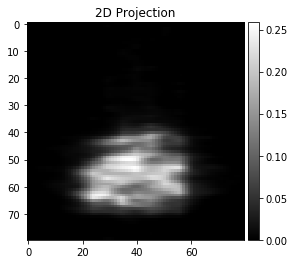

In [17]:
#Visualize image stacks
from mpl_toolkits.axes_grid1 import make_axes_locatable
image = np.transpose(ImgTensor.numpy(), (1,2,0))

def DisplayImage(img,LimMin,LimMax):  
    if img.shape[2]>1:
        for depth in range (0,10):
            plt.subplot(2,5,depth+1)
            plt.imshow(img[:,:,depth*8],vmin=LimMin, vmax=LimMax, cmap ='gray')
            # plt.colorbar()
            plt.title('z = '+ str(depth))
            if depth==9:
                plt.subplot(2,5,depth+1)
                plt.title('z = '+ str(depth))
                ax = plt.gca()
                fig4 = plt.imshow(img[:,:,depth*8],vmin=LimMin, vmax=LimMax, cmap ='gray')

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(fig4, cax=cax)
        plt.show()
    else:
        fig4 = plt.imshow(np.squeeze(img),vmin=LimMin, vmax=LimMax, cmap ='gray')
        plt.title('2D Projection')
        ax = plt.gca()
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(fig4, cax=cax)
        plt.show()
DisplayImage(image,image.min(),image.max())

In [18]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
#         transforms.RandomResizedCrop(input_size),
        transforms.Resize(input_size),
#         transforms.RandomHorizontalFlip(),
#         transforms.CenterCrop(input_size),
        transforms.ToTensor(),
#         transforms.Normalize([0.00351, 0.00351, 0.00351], [0.009389, 0.009389, 0.009389])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
#         transforms.CenterCrop(input_size),
        transforms.ToTensor(),
#         transforms.Normalize([0.00351, 0.00351, 0.00351], [0.009389, 0.009389, 0.009389])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


Fold- 0 : Initializing Datasets and Dataloaders...
Gra train data: 10870
Lym train data: 9795
Mon train data: 12153
H:\WBCDataset_v4\2DProjectionsKFold-aug\Gra_Y\Fold-1
Gra Val data: 2720
Gra mini-train data: 2176
Gra mini-val data: 544
Lym Val data: 2447
Lym mini-train data: 1957
Lym mini-val data: 490
Mon Val data: 3037
Mon mini-train data: 2429
Mon mini-val data: 608
Epoch 0/99
----------
LR 1e-06
train Loss: 1.0503 Acc: 0.4026
train Bal. Acc: 0.4126
val Loss: 0.9913 Acc: 0.5531
val Bal. Acc: 0.5776
saving best model
Total time: 0:00:30.252693
Epoch time: 0m 30s

Epoch 1/99
----------
LR 1e-06
train Loss: 0.9281 Acc: 0.5607
train Bal. Acc: 0.5808
val Loss: 0.8959 Acc: 0.5900
val Bal. Acc: 0.6075
saving best model
Total time: 0:00:59.437264
Epoch time: 0m 59s

Epoch 2/99
----------
LR 1e-06
train Loss: 0.8559 Acc: 0.6252
train Bal. Acc: 0.6400
val Loss: 0.8323 Acc: 0.6368
val Bal. Acc: 0.6501
saving best model
Total time: 0:01:28.724921
Epoch time: 1m 29s

Epoch 3/99
----------
LR 1e

train Loss: 0.4253 Acc: 0.8317
train Bal. Acc: 0.8294
val Loss: 0.4877 Acc: 0.7996
val Bal. Acc: 0.7975
Total time: 0:19:33.487446
Epoch time: 19m 33s

Epoch 40/99
----------
LR 1e-05
train Loss: 0.4204 Acc: 0.8344
train Bal. Acc: 0.8321
val Loss: 0.4863 Acc: 0.8006
val Bal. Acc: 0.7989
saving best model
Total time: 0:20:02.587371
Epoch time: 20m 3s

Epoch 41/99
----------
LR 1e-05
train Loss: 0.4168 Acc: 0.8355
train Bal. Acc: 0.8332
val Loss: 0.4859 Acc: 0.7996
val Bal. Acc: 0.7964
Total time: 0:20:31.667529
Epoch time: 20m 32s

Epoch 42/99
----------
LR 1e-05
train Loss: 0.4124 Acc: 0.8365
train Bal. Acc: 0.8344
val Loss: 0.4834 Acc: 0.8016
val Bal. Acc: 0.7989
saving best model
Total time: 0:21:00.876768
Epoch time: 21m 1s

Epoch 43/99
----------
LR 1e-05
train Loss: 0.4087 Acc: 0.8390
train Bal. Acc: 0.8369
val Loss: 0.4818 Acc: 0.8025
val Bal. Acc: 0.7999
saving best model
Total time: 0:21:30.047050
Epoch time: 21m 30s

Epoch 44/99
----------
LR 1e-05
train Loss: 0.4039 Acc: 0.84

train Loss: 0.2503 Acc: 0.9124
train Bal. Acc: 0.9119
val Loss: 0.4822 Acc: 0.8092
val Bal. Acc: 0.8076
Total time: 0:40:27.427698
Epoch time: 40m 27s

Epoch 83/99
----------
LR 1.25e-06
train Loss: 0.2461 Acc: 0.9149
train Bal. Acc: 0.9145
val Loss: 0.4845 Acc: 0.8091
val Bal. Acc: 0.8066
Total time: 0:40:56.666623
Epoch time: 40m 57s

Epoch 84/99
----------
LR 1.25e-06
train Loss: 0.2414 Acc: 0.9173
train Bal. Acc: 0.9169
val Loss: 0.4848 Acc: 0.8070
val Bal. Acc: 0.8058
Total time: 0:41:25.867638
Epoch time: 41m 26s

Epoch 85/99
----------
LR 1.25e-06
train Loss: 0.2384 Acc: 0.9191
train Bal. Acc: 0.9185
val Loss: 0.4859 Acc: 0.8088
val Bal. Acc: 0.8071
Total time: 0:41:55.072996
Epoch time: 41m 55s

Epoch 86/99
----------
LR 1.25e-06
train Loss: 0.2346 Acc: 0.9202
train Bal. Acc: 0.9197
val Loss: 0.4883 Acc: 0.8068
val Bal. Acc: 0.8055
Total time: 0:42:24.177861
Epoch time: 42m 24s

Epoch 87/99
----------
LR 1.25e-06
train Loss: 0.2299 Acc: 0.9231
train Bal. Acc: 0.9228
val Loss: 0

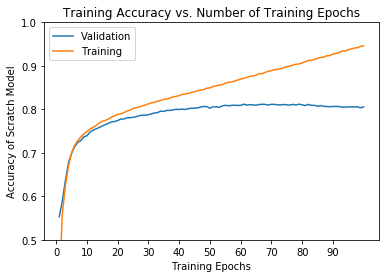

100


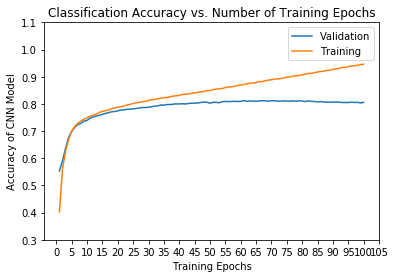

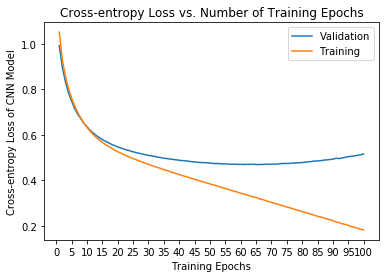

tensor([[2530.,   45.,  145.],
        [ 149., 1725.,  573.],
        [ 150.,  481., 2406.]])
[2829. 2251. 3124.]
[[0.93014705 0.01654412 0.05330882]
 [0.06089089 0.70494485 0.23416428]
 [0.04939085 0.15837999 0.7922292 ]]



Fold- 1 : Initializing Datasets and Dataloaders...
Gra train data: 10876
Lym train data: 9795
Mon train data: 12151


C:\Users\11821\.conda\envs\pytorch-gpu\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\11821\.conda\envs\pytorch-gpu\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\11821\.conda\envs\pytorch-gpu\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\11821\.conda\envs\pytorch-gpu\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type "

H:\WBCDataset_v4\2DProjectionsKFold-aug\Gra_Y\Fold-2
Gra Val data: 2714
Gra mini-train data: 2171
Gra mini-val data: 543
Lym Val data: 2447
Lym mini-train data: 1957
Lym mini-val data: 490
Mon Val data: 3039
Mon mini-train data: 2431
Mon mini-val data: 608
Epoch 0/99
----------
LR 1e-06
train Loss: 0.9826 Acc: 0.5351
train Bal. Acc: 0.5268
val Loss: 1.0641 Acc: 0.3413
val Bal. Acc: 0.3692
saving best model
Total time: 0:00:29.286363
Epoch time: 0m 29s

Epoch 1/99
----------
LR 1e-06
train Loss: 0.8739 Acc: 0.6348
train Bal. Acc: 0.6340
val Loss: 0.8453 Acc: 0.6435
val Bal. Acc: 0.6449
saving best model
Total time: 0:00:58.552581
Epoch time: 0m 59s

Epoch 2/99
----------
LR 1e-06
train Loss: 0.8188 Acc: 0.6672
train Bal. Acc: 0.6680
val Loss: 0.7999 Acc: 0.6670
val Bal. Acc: 0.6690
saving best model
Total time: 0:01:27.862634
Epoch time: 1m 28s

Epoch 3/99
----------
LR 1e-06
train Loss: 0.7794 Acc: 0.6878
train Bal. Acc: 0.6862
val Loss: 0.7665 Acc: 0.6812
val Bal. Acc: 0.6805
saving b

train Loss: 0.4131 Acc: 0.8348
train Bal. Acc: 0.8332
val Loss: 0.4863 Acc: 0.7998
val Bal. Acc: 0.7988
saving best model
Total time: 0:19:55.480393
Epoch time: 19m 55s

Epoch 41/99
----------
LR 1e-05
train Loss: 0.4094 Acc: 0.8381
train Bal. Acc: 0.8362
val Loss: 0.4840 Acc: 0.7998
val Bal. Acc: 0.7977
Total time: 0:20:24.611903
Epoch time: 20m 25s

Epoch 42/99
----------
LR 1e-05
train Loss: 0.4048 Acc: 0.8399
train Bal. Acc: 0.8383
val Loss: 0.4844 Acc: 0.7991
val Bal. Acc: 0.7988
Total time: 0:20:53.806786
Epoch time: 20m 54s

Epoch 43/99
----------
LR 1e-05
train Loss: 0.4016 Acc: 0.8419
train Bal. Acc: 0.8400
val Loss: 0.4820 Acc: 0.8021
val Bal. Acc: 0.7999
saving best model
Total time: 0:21:23.078939
Epoch time: 21m 23s

Epoch 44/99
----------
LR 1e-05
train Loss: 0.3967 Acc: 0.8438
train Bal. Acc: 0.8425
val Loss: 0.4807 Acc: 0.8028
val Bal. Acc: 0.8011
saving best model
Total time: 0:21:52.307416
Epoch time: 21m 52s

Epoch 45/99
----------
LR 1e-05
train Loss: 0.3920 Acc: 0.

train Loss: 0.2454 Acc: 0.9145
train Bal. Acc: 0.9141
val Loss: 0.4809 Acc: 0.8073
val Bal. Acc: 0.8073
Total time: 0:40:37.186191
Epoch time: 40m 37s

Epoch 83/99
----------
LR 1.25e-06
train Loss: 0.2409 Acc: 0.9164
train Bal. Acc: 0.9159
val Loss: 0.4845 Acc: 0.8085
val Bal. Acc: 0.8075
Total time: 0:41:06.334833
Epoch time: 41m 6s

Epoch 84/99
----------
LR 1.25e-06
train Loss: 0.2381 Acc: 0.9173
train Bal. Acc: 0.9169
val Loss: 0.4833 Acc: 0.8109
val Bal. Acc: 0.8094
Total time: 0:41:35.416372
Epoch time: 41m 35s

Epoch 85/99
----------
LR 1.25e-06
train Loss: 0.2336 Acc: 0.9203
train Bal. Acc: 0.9200
val Loss: 0.4867 Acc: 0.8067
val Bal. Acc: 0.8068
Total time: 0:42:04.516479
Epoch time: 42m 5s

Epoch 86/99
----------
LR 1.25e-06
train Loss: 0.2282 Acc: 0.9219
train Bal. Acc: 0.9214
val Loss: 0.4858 Acc: 0.8093
val Bal. Acc: 0.8085
Total time: 0:42:33.797072
Epoch time: 42m 34s

Epoch 87/99
----------
LR 1.25e-06
train Loss: 0.2247 Acc: 0.9240
train Bal. Acc: 0.9236
val Loss: 0.4

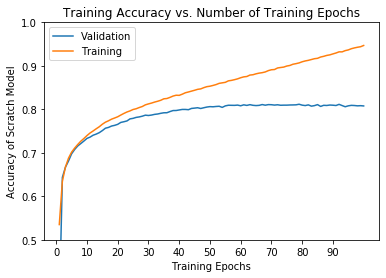

100


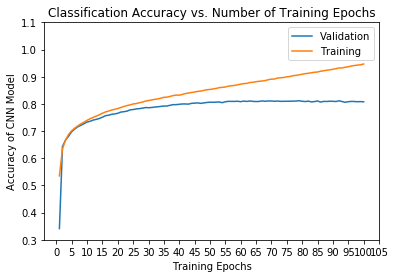

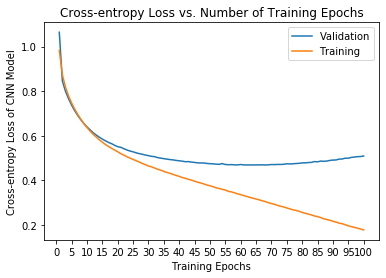

tensor([[2496.,   49.,  169.],
        [ 126., 1762.,  559.],
        [ 158.,  483., 2398.]])
[2780. 2294. 3126.]
[[0.91967577 0.01805453 0.06226971]
 [0.05149162 0.7200654  0.228443  ]
 [0.05199078 0.15893386 0.7890754 ]]



Fold- 2 : Initializing Datasets and Dataloaders...
Gra train data: 10871
Lym train data: 9791
Mon train data: 12153
H:\WBCDataset_v4\2DProjectionsKFold-aug\Gra_Y\Fold-3
Gra Val data: 2719
Gra mini-train data: 2175
Gra mini-val data: 544
Lym Val data: 2451
Lym mini-train data: 1960
Lym mini-val data: 491
Mon Val data: 3037
Mon mini-train data: 2429
Mon mini-val data: 608
Epoch 0/99
----------
LR 1e-06
train Loss: 1.0283 Acc: 0.4889
train Bal. Acc: 0.4934
val Loss: 1.0238 Acc: 0.4116
val Bal. Acc: 0.4336
saving best model
Total time: 0:00:29.072662
Epoch time: 0m 29s

Epoch 1/99
----------
LR 1e-06
train Loss: 0.8905 Acc: 0.6204
train Bal. Acc: 0.6262
val Loss: 0.8584 Acc: 0.6414
val Bal. Acc: 0.6481
saving best model
Total time: 0:00:58.124415
Epoch time: 0m 58s

E

train Loss: 0.4336 Acc: 0.8246
train Bal. Acc: 0.8226
val Loss: 0.5052 Acc: 0.7910
val Bal. Acc: 0.7873
saving best model
Total time: 0:18:58.423559
Epoch time: 18m 58s

Epoch 39/99
----------
LR 1e-05
train Loss: 0.4293 Acc: 0.8267
train Bal. Acc: 0.8247
val Loss: 0.5035 Acc: 0.7921
val Bal. Acc: 0.7886
saving best model
Total time: 0:19:27.645403
Epoch time: 19m 28s

Epoch 40/99
----------
LR 1e-05
train Loss: 0.4267 Acc: 0.8286
train Bal. Acc: 0.8269
val Loss: 0.5015 Acc: 0.7933
val Bal. Acc: 0.7905
saving best model
Total time: 0:19:56.883364
Epoch time: 19m 57s

Epoch 41/99
----------
LR 1e-05
train Loss: 0.4212 Acc: 0.8303
train Bal. Acc: 0.8284
val Loss: 0.5001 Acc: 0.7949
val Bal. Acc: 0.7916
saving best model
Total time: 0:20:26.172573
Epoch time: 20m 26s

Epoch 42/99
----------
LR 1e-05
train Loss: 0.4171 Acc: 0.8332
train Bal. Acc: 0.8315
val Loss: 0.5001 Acc: 0.7953
val Bal. Acc: 0.7908
saving best model
Total time: 0:20:55.272223
Epoch time: 20m 55s

Epoch 43/99
----------

train Loss: 0.2601 Acc: 0.9095
train Bal. Acc: 0.9092
val Loss: 0.5016 Acc: 0.7990
val Bal. Acc: 0.7953
Total time: 0:39:41.938674
Epoch time: 39m 42s

Epoch 82/99
----------
LR 1.25e-06
train Loss: 0.2566 Acc: 0.9103
train Bal. Acc: 0.9102
val Loss: 0.5006 Acc: 0.8018
val Bal. Acc: 0.7998
Total time: 0:40:10.722668
Epoch time: 40m 11s

Epoch 83/99
----------
LR 1.25e-06
train Loss: 0.2524 Acc: 0.9129
train Bal. Acc: 0.9128
val Loss: 0.5018 Acc: 0.8011
val Bal. Acc: 0.7991
Total time: 0:40:39.522767
Epoch time: 40m 40s

Epoch 84/99
----------
LR 1.25e-06
train Loss: 0.2479 Acc: 0.9139
train Bal. Acc: 0.9137
val Loss: 0.5028 Acc: 0.8013
val Bal. Acc: 0.7992
Total time: 0:41:08.367582
Epoch time: 41m 8s

Epoch 85/99
----------
LR 1.25e-06
train Loss: 0.2440 Acc: 0.9157
train Bal. Acc: 0.9154
val Loss: 0.5042 Acc: 0.7993
val Bal. Acc: 0.7969
Total time: 0:41:37.123420
Epoch time: 41m 37s

Epoch 86/99
----------
LR 1.25e-06
train Loss: 0.2391 Acc: 0.9181
train Bal. Acc: 0.9178
val Loss: 0.

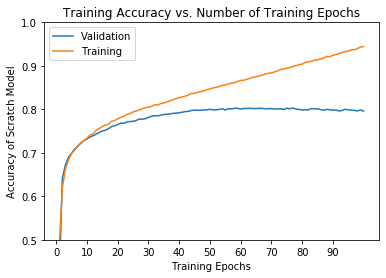

100


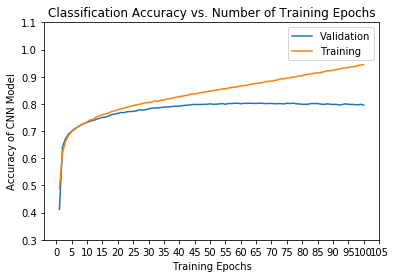

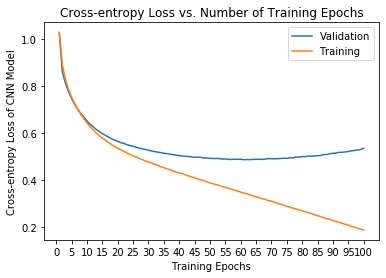

tensor([[2495.,   61.,  163.],
        [ 158., 1758.,  535.],
        [ 162.,  539., 2336.]])
[2815. 2358. 3034.]
[[0.9176168  0.02243472 0.05994851]
 [0.06446348 0.7172583  0.21827826]
 [0.05334212 0.17747778 0.7691801 ]]



Fold- 3 : Initializing Datasets and Dataloaders...
Gra train data: 10873
Lym train data: 9795
Mon train data: 12153
H:\WBCDataset_v4\2DProjectionsKFold-aug\Gra_Y\Fold-4
Gra Val data: 2717
Gra mini-train data: 2173
Gra mini-val data: 544
Lym Val data: 2447
Lym mini-train data: 1957
Lym mini-val data: 490
Mon Val data: 3037
Mon mini-train data: 2429
Mon mini-val data: 608
Epoch 0/99
----------
LR 1e-06
train Loss: 1.1640 Acc: 0.3168
train Bal. Acc: 0.3512
val Loss: 1.2918 Acc: 0.2984
val Bal. Acc: 0.3333
saving best model
Total time: 0:00:28.795484
Epoch time: 0m 29s

Epoch 1/99
----------
LR 1e-06
train Loss: 0.9879 Acc: 0.4320
train Bal. Acc: 0.4641
val Loss: 0.9329 Acc: 0.4780
val Bal. Acc: 0.5072
saving best model
Total time: 0:00:57.578215
Epoch time: 0m 58s

E

train Loss: 0.4384 Acc: 0.8263
train Bal. Acc: 0.8236
val Loss: 0.4762 Acc: 0.8049
val Bal. Acc: 0.8024
Total time: 0:18:43.375586
Epoch time: 18m 43s

Epoch 39/99
----------
LR 1e-05
train Loss: 0.4335 Acc: 0.8281
train Bal. Acc: 0.8259
val Loss: 0.4737 Acc: 0.8075
val Bal. Acc: 0.8056
saving best model
Total time: 0:19:12.166005
Epoch time: 19m 12s

Epoch 40/99
----------
LR 1e-05
train Loss: 0.4291 Acc: 0.8301
train Bal. Acc: 0.8278
val Loss: 0.4716 Acc: 0.8078
val Bal. Acc: 0.8060
saving best model
Total time: 0:19:41.000221
Epoch time: 19m 41s

Epoch 41/99
----------
LR 1e-05
train Loss: 0.4249 Acc: 0.8326
train Bal. Acc: 0.8304
val Loss: 0.4690 Acc: 0.8099
val Bal. Acc: 0.8080
saving best model
Total time: 0:20:09.775756
Epoch time: 20m 10s

Epoch 42/99
----------
LR 1e-05
train Loss: 0.4210 Acc: 0.8349
train Bal. Acc: 0.8327
val Loss: 0.4670 Acc: 0.8120
val Bal. Acc: 0.8101
saving best model
Total time: 0:20:38.625428
Epoch time: 20m 39s

Epoch 43/99
----------
LR 1e-05
train Lo

val Loss: 0.4478 Acc: 0.8260
val Bal. Acc: 0.8249
Total time: 0:38:55.195763
Epoch time: 38m 55s

Epoch    75: reducing learning rate of group 0 to 2.5000e-06.
Epoch 81/99
----------
LR 2.5e-06
train Loss: 0.2598 Acc: 0.9083
train Bal. Acc: 0.9073
val Loss: 0.4500 Acc: 0.8247
val Bal. Acc: 0.8234
Total time: 0:39:24.397569
Epoch time: 39m 24s

Epoch 82/99
----------
LR 2.5e-06
train Loss: 0.2554 Acc: 0.9101
train Bal. Acc: 0.9092
val Loss: 0.4491 Acc: 0.8267
val Bal. Acc: 0.8257
Total time: 0:39:53.555625
Epoch time: 39m 54s

Epoch 83/99
----------
LR 2.5e-06
train Loss: 0.2522 Acc: 0.9123
train Bal. Acc: 0.9114
val Loss: 0.4516 Acc: 0.8242
val Bal. Acc: 0.8218
Total time: 0:40:22.590552
Epoch time: 40m 23s

Epoch 84/99
----------
LR 2.5e-06
train Loss: 0.2487 Acc: 0.9128
train Bal. Acc: 0.9121
val Loss: 0.4509 Acc: 0.8254
val Bal. Acc: 0.8238
Total time: 0:40:51.890783
Epoch time: 40m 52s

Epoch 85/99
----------
LR 2.5e-06
train Loss: 0.2435 Acc: 0.9161
train Bal. Acc: 0.9154
val Loss

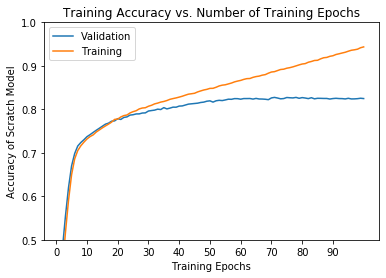

100


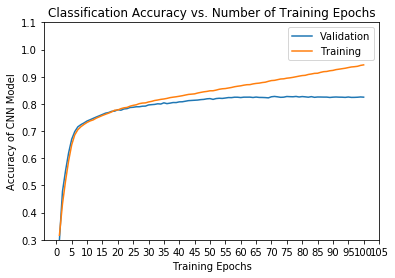

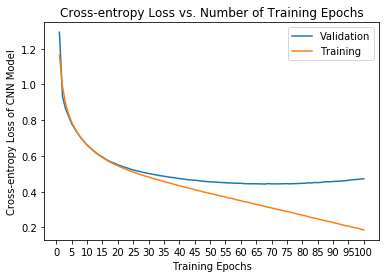

tensor([[2506.,   55.,  156.],
        [ 147., 1878.,  422.],
        [ 166.,  469., 2402.]])
[2819. 2402. 2980.]
[[0.9223408  0.02024291 0.05741627]
 [0.06007356 0.76747036 0.17245607]
 [0.0546592  0.1544287  0.7909121 ]]



Fold- 4 : Initializing Datasets and Dataloaders...
Gra train data: 10873
Lym train data: 9795
Mon train data: 12153
H:\WBCDataset_v4\2DProjectionsKFold-aug\Gra_Y\Fold-5
Gra Val data: 2717
Gra mini-train data: 2173
Gra mini-val data: 544
Lym Val data: 2447
Lym mini-train data: 1957
Lym mini-val data: 490
Mon Val data: 3037
Mon mini-train data: 2429
Mon mini-val data: 608
Epoch 0/99
----------
LR 1e-06
train Loss: 1.1453 Acc: 0.3664
train Bal. Acc: 0.4003
val Loss: 1.1717 Acc: 0.3095
val Bal. Acc: 0.3442
saving best model
Total time: 0:00:29.270021
Epoch time: 0m 29s

Epoch 1/99
----------
LR 1e-06
train Loss: 0.9943 Acc: 0.4843
train Bal. Acc: 0.5168
val Loss: 0.9490 Acc: 0.5104
val Bal. Acc: 0.5429
saving best model
Total time: 0:00:58.313887
Epoch time: 0m 58s

E

train Loss: 0.4298 Acc: 0.8282
train Bal. Acc: 0.8260
val Loss: 0.4753 Acc: 0.8028
val Bal. Acc: 0.8012
Total time: 0:18:57.994903
Epoch time: 18m 58s

Epoch 39/99
----------
LR 1e-05
train Loss: 0.4254 Acc: 0.8304
train Bal. Acc: 0.8284
val Loss: 0.4735 Acc: 0.8042
val Bal. Acc: 0.8026
saving best model
Total time: 0:19:27.133443
Epoch time: 19m 27s

Epoch 40/99
----------
LR 1e-05
train Loss: 0.4207 Acc: 0.8320
train Bal. Acc: 0.8301
val Loss: 0.4721 Acc: 0.8054
val Bal. Acc: 0.8044
saving best model
Total time: 0:19:56.357278
Epoch time: 19m 56s

Epoch 41/99
----------
LR 1e-05
train Loss: 0.4174 Acc: 0.8326
train Bal. Acc: 0.8306
val Loss: 0.4701 Acc: 0.8059
val Bal. Acc: 0.8043
saving best model
Total time: 0:20:25.413089
Epoch time: 20m 25s

Epoch 42/99
----------
LR 1e-05
train Loss: 0.4127 Acc: 0.8357
train Bal. Acc: 0.8338
val Loss: 0.4681 Acc: 0.8066
val Bal. Acc: 0.8052
saving best model
Total time: 0:20:54.448246
Epoch time: 20m 54s

Epoch 43/99
----------
LR 1e-05
train Lo

train Loss: 0.2604 Acc: 0.9054
train Bal. Acc: 0.9050
val Loss: 0.4585 Acc: 0.8179
val Bal. Acc: 0.8178
Total time: 0:39:22.943479
Epoch time: 39m 23s

Epoch 81/99
----------
LR 2.5e-06
train Loss: 0.2570 Acc: 0.9075
train Bal. Acc: 0.9070
val Loss: 0.4597 Acc: 0.8156
val Bal. Acc: 0.8146
Total time: 0:39:52.043486
Epoch time: 39m 52s

Epoch 82/99
----------
LR 2.5e-06
train Loss: 0.2530 Acc: 0.9092
train Bal. Acc: 0.9088
val Loss: 0.4603 Acc: 0.8172
val Bal. Acc: 0.8158
Total time: 0:40:21.149142
Epoch time: 40m 21s

Epoch 83/99
----------
LR 2.5e-06
train Loss: 0.2488 Acc: 0.9119
train Bal. Acc: 0.9114
val Loss: 0.4633 Acc: 0.8138
val Bal. Acc: 0.8122
Total time: 0:40:50.312433
Epoch time: 40m 50s

Epoch 84/99
----------
LR 2.5e-06
train Loss: 0.2449 Acc: 0.9135
train Bal. Acc: 0.9131
val Loss: 0.4624 Acc: 0.8160
val Bal. Acc: 0.8148
Total time: 0:41:19.448894
Epoch time: 41m 19s

Epoch    79: reducing learning rate of group 0 to 1.2500e-06.
Epoch 85/99
----------
LR 1.25e-06
train L

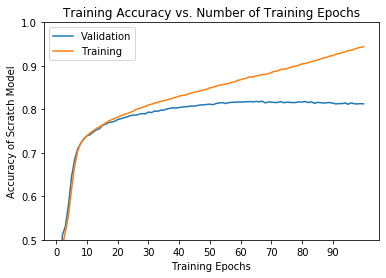

100


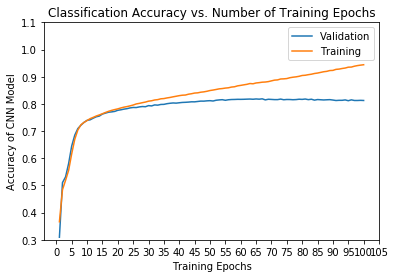

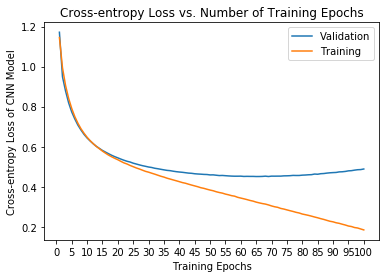

tensor([[2495.,   51.,  171.],
        [ 132., 1861.,  454.],
        [ 185.,  494., 2358.]])
[2812. 2406. 2983.]
[[0.9182922  0.0187707  0.06293707]
 [0.0539436  0.7605231  0.1855333 ]
 [0.06091538 0.16266052 0.7764241 ]]





In [19]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import copy

for runs in range (0,5):
    print("Fold-",str(runs),": Initializing Datasets and Dataloaders...")
    #Kfold
    Fold = runs
    trainpath,testpath,minitrainpath,minitestpath= datapreparation(DatadirTrain,DatadirVal,Fold)
    image_datasets = {}
    image_datasets['train'] = MyDataset(trainpath)
    image_datasets['val'] = MyDataset(testpath)

    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}

    # Detect if we have a GPU available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    num_class = 3
    in_channel = 1
    num_epochs = 100
    loss_hist_train = []
    while (len(loss_hist_train)<num_epochs/2):
        # Setup the loss fxn
        criterion = nn.CrossEntropyLoss()
        # Initialize the non-pretrained version of the model used for this run
        scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
        scratch_model = scratch_model.to(device)
    #     scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.0005, momentum=0.9)
    #     scratch_optimizer = optim.Adam(scratch_model.parameters(),lr=0.00001,betas = (0.9, 0.9999),eps=1e-08,weight_decay=0)
        scratch_optimizer = optim.Adam(scratch_model.parameters(),lr=1e-6,betas = (0.9, 0.999),eps=1e-08,weight_decay=0)
        scratch_optimizer2 = optim.Adam(scratch_model.parameters(),lr=1e-5,betas = (0.9, 0.999),eps=1e-08,weight_decay=0)
        scratch_criterion = nn.CrossEntropyLoss()
        model, scratch_hist_val,scratch_hist_train,loss_hist_train, loss_hist_val,lr_hist,train_Bacc_hist,val_Bacc_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, scratch_optimizer2, num_epochs=num_epochs, is_inception=(model_name=="inception"))
        if len(loss_hist_train)<num_epochs:
            print('model diverges, reinitializing training....\n')
            print("Fold-",str(runs),": Initializing Datasets and Dataloaders...")
        
    # num_epochs=15
    fname1 = "training_acc_"+str(runs)+".csv"
    np.savetxt(fname1,scratch_hist_train , delimiter=",")
    fname2 = "validation_acc_"+str(runs)+".csv"
    np.savetxt(fname2,scratch_hist_val , delimiter=",")
    fname13 = "training_Bacc_"+str(runs)+".csv"
    np.savetxt(fname13,train_Bacc_hist, delimiter=",")
    fname23 = "validation_Bacc_"+str(runs)+".csv"
    np.savetxt(fname23,val_Bacc_hist, delimiter=",")
    fname20 = "training_loss_"+str(runs)+".csv"
    np.savetxt(fname20,loss_hist_train , delimiter=",")
    fname21 = "validation_loss_"+str(runs)+".csv"
    np.savetxt(fname21,loss_hist_val , delimiter=",")
    fname22 = "learning_rate_"+str(runs)+".csv"
    np.savetxt(fname22,lr_hist , delimiter=",")
    
    shist = []
    shist1 = []

    shist = [h.cpu().numpy() for h in scratch_hist_val]
    shist1 = [h.cpu().numpy() for h in scratch_hist_train]
    print(len(shist))
    plt.title("Training Accuracy vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Accuracy of Scratch Model")
    plt.plot(range(1,len(shist)+1),shist[0:len(shist)],label="Validation")
    plt.plot(range(1,len(shist)+1),shist1[0:len(shist)],label="Training")
    plt.ylim((0.5,1.))
    plt.xticks(np.arange(0, num_epochs, 10.0))
    plt.legend()
    fname3 = 'training_curve_'+str(runs)+'.png'
    plt.savefig(fname3)
    plt.show()

    shist = [h.cpu().numpy() for h in scratch_hist_val]
    shist1 = [h.cpu().numpy() for h in scratch_hist_train]
    print(len(shist))
    plt.title("Classification Accuracy vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Accuracy of CNN Model")
    plt.plot(range(1,len(shist)+1),shist[0:len(shist)],label="Validation")
    plt.plot(range(1,len(shist)+1),shist1[0:len(shist)],label="Training")
    plt.ylim((0.3,1.1))
    plt.xticks(np.arange(0, len(shist)+10, 5.0))
    plt.legend()
    fname3 = 'training_curve_'+str(runs)+'backup'+'.png'
    plt.savefig(fname3)
    plt.show()

    train_loss = [h for h in loss_hist_train]
    val_loss = [h for h in loss_hist_val]
    plt.title("Cross-entropy Loss vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Cross-entropy Loss of CNN Model")
    plt.plot(range(1,len(val_loss)+1),val_loss[0:len(val_loss)],label="Validation")
    plt.plot(range(1,len(train_loss)+1),train_loss[0:len(train_loss)],label="Training")
    #     plt.ylim((0.5,1.05))
    plt.xticks(np.arange(0, len(val_loss)+5, 5.0))
    plt.legend()
    fname31 = 'loss_curve_'+str(runs)+'.png'
    plt.savefig(fname31)
    plt.show()

    confusion_matrix = torch.zeros(num_classes, num_classes)
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(dataloaders_dict['val']):
            inputs = inputs.type(torch.FloatTensor)
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1

    print(confusion_matrix)
    confusionMat = np.asarray(confusion_matrix)
    sumconfusion = np.sum(confusionMat,axis = 0)
    print(sumconfusion)

    import scipy
    sumconfusion = np.sum(confusionMat,axis = 1).T
    # print(np.tile(sumconfusion,(4,1)))
    summat = np.tile(sumconfusion,(3,1)).T
    # print(test)
    percentconfusion = np.divide(confusionMat,summat)
    print(percentconfusion)
    fname4 = "confusion_Mat_UNet_confusionMat_"+str(runs)+".csv"
    np.savetxt(fname4,confusionMat , delimiter=",")
    fname5 = "confusion_Mat_UNet_confusionPer_"+str(runs)+".csv"
    np.savetxt(fname5,percentconfusion , delimiter=",")
    fname6 = 'WBCmodel-ResNet18-2D_Run_'+str(runs)+'.pth.tar'

    torch.save(model,fname6)
    print('\n\n')

In [ ]:
confusion_matrix = torch.zeros(num_classes, num_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders_dict['val']):
        inputs = inputs.type(torch.FloatTensor)
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)
confusionMat = np.asarray(confusion_matrix)
sumconfusion = np.sum(confusionMat,axis = 0)
print(sumconfusion)

import scipy
sumconfusion = np.sum(confusionMat,axis = 1).T
# print(np.tile(sumconfusion,(4,1)))
summat = np.tile(sumconfusion,(3,1)).T
# print(test)
percentconfusion = np.divide(confusionMat,summat)
print(percentconfusion)
fname4 = "confusion_Mat_UNet_confusionMat_"+str(runs)+".csv"
np.savetxt(fname4,confusionMat , delimiter=",")
fname5 = "confusion_Mat_UNet_confusionPer_"+str(runs)+".csv"
np.savetxt(fname5,percentconfusion , delimiter=",")
fname6 = 'WBCmodel-ResNet18-2D_Run_'+str(runs)+'.pth.tar'

torch.save(model,fname6)
print('\n\n')

In [ ]:
fname1 = "training_acc_"+str(runs)+".csv"
np.savetxt(fname1,scratch_hist_train , delimiter=",")
fname2 = "validation_acc_"+str(runs)+".csv"
np.savetxt(fname2,scratch_hist_val , delimiter=",")
fname13 = "training_Bacc_"+str(runs)+".csv"
np.savetxt(fname13,train_Bacc_hist, delimiter=",")
fname23 = "validation_Bacc_"+str(runs)+".csv"
np.savetxt(fname23,val_Bacc_hist, delimiter=",")
fname20 = "training_loss_"+str(runs)+".csv"
np.savetxt(fname20,loss_hist_train , delimiter=",")
fname21 = "validation_loss_"+str(runs)+".csv"
np.savetxt(fname21,loss_hist_val , delimiter=",")
fname22 = "learning_rate_"+str(runs)+".csv"
np.savetxt(fname22,lr_hist , delimiter=",")

shist = []
shist1 = []

shist = scratch_hist_val
shist1 = scratch_hist_train
print(len(shist))
plt.title("Training Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy of Scratch Model")
plt.plot(range(1,len(shist)+1),shist[0:len(shist)],label="Validation")
plt.plot(range(1,len(shist)+1),shist1[0:len(shist)],label="Training")
plt.ylim((0.5,1.))
plt.xticks(np.arange(0, num_epochs, 10.0))
plt.legend()
fname3 = 'training_curve_'+str(runs)+'.png'
plt.savefig(fname3)
plt.show()

shist = [h.cpu().numpy() for h in scratch_hist_val]
shist1 = [h.cpu().numpy() for h in scratch_hist_train]
print(len(shist))
plt.title("Classification Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy of CNN Model")
plt.plot(range(1,len(shist)+1),shist[0:len(shist)],label="Validation")
plt.plot(range(1,len(shist)+1),shist1[0:len(shist)],label="Training")
plt.ylim((0.3,1.1))
plt.xticks(np.arange(0, len(shist)+10, 5.0))
plt.legend()
fname3 = 'training_curve_'+str(runs)+'backup'+'.png'
plt.savefig(fname3)
plt.show()

train_loss = [h for h in loss_hist_train]
val_loss = [h for h in loss_hist_val]
plt.title("Cross-entropy Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Cross-entropy Loss of CNN Model")
plt.plot(range(1,len(val_loss)+1),val_loss[0:len(val_loss)],label="Validation")
plt.plot(range(1,len(train_loss)+1),train_loss[0:len(train_loss)],label="Training")
#     plt.ylim((0.5,1.05))
plt.xticks(np.arange(0, len(val_loss)+5, 5.0))
plt.legend()
fname31 = 'loss_curve_'+str(runs)+'.png'
plt.savefig(fname31)
plt.show()

confusion_matrix = torch.zeros(num_classes, num_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders_dict['val']):
        inputs = inputs.type(torch.FloatTensor)
        inputs = inputs.to(device)
        classes = classes.to(device)
        _, outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)
confusionMat = np.asarray(confusion_matrix)
sumconfusion = np.sum(confusionMat,axis = 0)
print(sumconfusion)

import scipy
sumconfusion = np.sum(confusionMat,axis = 1).T
# print(np.tile(sumconfusion,(4,1)))
summat = np.tile(sumconfusion,(3,1)).T
# print(test)
percentconfusion = np.divide(confusionMat,summat)
print(percentconfusion)
fname4 = "confusion_Mat_ResNet_confusionMat_"+str(runs)+".csv"
np.savetxt(fname4,confusionMat , delimiter=",")
fname5 = "confusion_Mat_ResNet_confusionPer_"+str(runs)+".csv"
np.savetxt(fname5,percentconfusion , delimiter=",")
fname6 = 'celltypemodel-ResNet_3D_Run_'+str(runs)+'.pth.tar'

torch.save(model,fname6)
print('\n\n')

In [ ]:
import seaborn as sns
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.1%}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.tile(np.sum(cf,axis = 0),(3,))]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))
#         accuracy  = np.trace(cf) / 3
        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nBalanced Accuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [ ]:
CellName = ['HEK293','HELA','MCF7']
categories = CellName
make_confusion_matrix(percentconfusion, 
                      #group_names=labels,
                      categories=categories,
                      percent=False,
                      cbar=False,
                      figsize=(4 ,4),
                      cmap='Blues',title = 'ResNet18 - 3D Input')

In [ ]:
# Initialize the non-pretrained version of the model used for this run
scratch_model = torch.load('celltypemodel-resnet_80rech_Run_1.pth.tar')
scratch_model_fc = nn.Sequential(*(list(scratch_model.children())[:-1]))
scratch_model_fc = scratch_model_fc.to(device)
scratch_model_fc.eval()

In [ ]:
#testing
image_datasets = {}
test_datasets ={}
image_datasets['train'] = MyDataset(trainpath)
image_datasets['val'] = MyDataset(testpath)
image_datasets['val'].__getitem__(0)[0].shape

In [ ]:
# Create training and test dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders_dict['val']):
        inputs = inputs.type(torch.FloatTensor)
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = scratch_model_fc(inputs).cpu().clone().numpy()
        if i == 0:
            outputlist = outputs
            y = classes.cpu().clone().numpy()
        else:
            outputlist = np.append(outputlist,outputs, axis=0)
            y = np.append(y,classes.cpu().clone().numpy(), axis=0)

In [ ]:
print(len(outputlist))
print(outputlist.shape)
print(y.shape)
outputlist = np.squeeze(outputlist)
print(outputlist.shape)

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
tsne = TSNE(n_components=2, random_state=0,verbose=1, perplexity=45, learning_rate=200,early_exaggeration = 40, n_iter=4000)
X_2d = tsne.fit_transform(outputlist)
CellName = ['HEK293','HELA','MCF7']

In [ ]:

target_ids = range(len(outputlist))
plt.figure(figsize=(4,4))
colors = 'r', 'g', 'b'
for i, c, label in zip(target_ids, colors, CellName):
    plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1],s=3, c=c, label=label,alpha=0.5)
plt.legend()
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('ResNet18 - 3D Input')
plt.show()